In [56]:
from sklearn.datasets import make_regression
from sklearn import linear_model

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import sys
# Imports for the solution

import pandas as pd
import seaborn as sb

sb.set(style="darkgrid")

from scipy.stats import mode

from sklearn.preprocessing import StandardScaler

import os

from IPython.core.display import HTML

# Defining the display of generated image in the centre of the page.
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

scaler = StandardScaler()

In [112]:
'''
    (EDA)is an approach to analyzing data sets to summarize their 
    main characteristics, often with visual methods. 
    A statistical model can be used or not, but primarily EDA is for seeing 
    what the data can tell us beyond the formal modeling or hypothesis testing task.
'''


def print_line():
    print("".center(80, '='))


class EDA:
    def __init__(self,
                 describe=False,
                 d_type=False,
                 null_check=False,
                 outlier=False,
                 verbose=False,
                 plot=False):
        self._describe = describe
        self._dtype = d_type
        self._null = null_check
        self._outlier = outlier
        self._verbose = verbose
        self._plot = plot
        if self._verbose:
            print(
                'EDA initialized and set to Describe [ {} ], DType Check [ {} ], Null Check [ {} ], Outlier Check [ {} ], Plot Graphs [ {} ]'
                .format(self._describe, self._dtype, self._null, self._outlier,
                        self._plot))

    def describe(self, file_name, y_col_name):
        try:
            if self._verbose:
                print_line()
                print('EDA for DataFrame : {}'.format(file_name))
                print_line()

            data_set = pd.read_csv(file_name)
            data_frame = pd.DataFrame(data_set)

            #DataFrame shape
            if self._verbose:
                print('Given Data Frame is of size  Rows[{}], columns[{}]'.
                      format(data_set.shape[0], data_set.shape[1]))

            #Describing the DataFrame
            if self._describe:
                print_line()
                print(data_set.describe())
                print_line()

            if self._null:
                null_list = self.check_null(data_set)
                print(
                    'No of Columns in DataFrame with Null values : {}'.format(
                        null_list.size))
                if self._verbose and null_list.size > 0:
                    print(
                        'Below are the Columns with Null Values being exist:')

            if self._dtype:
                print_line()
                print(
                    'Existence of Object or String type in the DataFrame : {}'.
                    format(self.find_scalar(data_set.dtypes)))

            #Scale Data
            data_set = self.scale_data(data_set)

            #Segregate the X, Ys for Further Analysis
            target_data = data_set[y_col_name]
            feature_data = data_set.drop(y_col_name, axis=1)

            if self._plot:
                #Box Plotting
                print_line()
                print(
                    'Visualization of Data - Plots[Box, Scatter, Correlation HeatMap, Correlation]'
                )
                self.check_outliers(feature_data)
                print_line()
                self.box_plot_all(feature_data)

                #Scatter Plot
                self.scatter_plot_all(target_data, feature_data,
                                      feature_data.columns)

                #Correlation HeatMap
                corr_matrix = data_frame.corr()
                print('Features Correlation with Target :')
                print_line()
                print(corr_matrix[y_col_name])
                print_line()
                print('Heat Map')
                sb.heatmap(corr_matrix, annot=True)

                #Pair Plot
                print(
                    'Pair Plot showing the correlation of {} to the target {}'.
                    format(feature_data.columns, y_col_name))
                print_line()
                sb.pairplot(data_frame,
                            kind="reg",
                            x_vars=feature_data.columns,
                            y_vars=[y_col_name],
                            diag_kind="kde")

        except AttributeError as err:
            print(
                'Unable to Process the DataFrame given [{}]'.format(file_name),
                err)

    '''
        Random Color generation function used during plotting
    '''
    def get_color(self):
        rgd = np.random.rand(3, )
        #if self._verbose:
        #    print('Obtained Color RGD[{}]'.format(rgd))
        return rgd

    '''
        
    '''
    def check_null(self, data_set):
        null_list = data_set.isnull().sum()
        return null_list[null_list != 0]

    '''
        Except Continuous everything is considered as non-scalar
    '''
    def find_scalar(self, type_arr):
        isScalar = False
        for ty in type_arr:
            if ty == 'object':
                isScalar = True
                break
        return isScalar

    def scale_data(self, data_set):
        return (data_set - data_set.mean()) / data_set.std()

    '''
        Box Plots everything into one Plot so the outliers can be viewed
    '''
    def box_plot_all(self, data_set):
        sb.boxplot(data=data_set, orient='h', palette="Set2")
        plt.show()

    '''
    Scatterplot All is used to plot x,y where x can be as many as; 
    and display the relationship between target and training features.
    '''
    def scatter_plot_all(self, y, data_set, columns):
        if columns.size == data_set.shape[1]:
            for col in columns:
                #print(bagdata[col])
                plt.scatter(y,
                            data_set[col],
                            color=self.get_color(),
                            label=col)

        plt.xlabel("$X(0..n)$", fontsize=18)
        plt.ylabel("$Y$", rotation=0, fontsize=18)
        plt.legend()
        plt.show()

    '''
        Returns the columns which has the outliers in them
    '''
    def check_outliers(self, data_set):
        columns_with_outliers = []
        for i in range(data_set.shape[1]):
            outlier_cnt = len(
                self.detect_outliers(data_set[data_set.columns[i]]))
            if outlier_cnt > 0:
                columns_with_outliers.append(data_set.columns[i])
                if self._verbose:
                    print_line()
                    print(
                        'Existence of Outlier for the Column [{}] and the No. of Outliers present : {}'
                        .format(data_set.columns[i], outlier_cnt))
        return columns_with_outliers

    '''
        One way to perform the Outlier analysis is with the help of 'Standard Deviation' 
        where anything that is not in the 3rd standard deviation or 3 Sigma limits is far from the population.
        
        Let’s consider a manufacturing firm that runs a series of 10 tests 
        to determine whether there is a variation in the quality of its products. 
        The data points for the 10 tests are 8.4, 8.5, 9.1, 9.3, 9.4, 9.5, 9.7, 9.7, 9.9, and 9.9.

        First, calculate the average of the observed data. 
                (8.4 + 8.5 + 9.1 + 9.3 + 9.4 + 9.5 + 9.7 + 9.7 + 9.9 + 9.9) / 10 
                which equals 93.4 / 10 = 9.34.
        
        Second, calculate the variance of the set. 
            Variance is the spread between data points and is 
            calculated as the sum of the squares of the difference between each data point
            and the mean divided by the number of observations. 
            The first difference square will be calculated as (8.4 - 9.34)2 = 0.8836, 
            the second square of difference will be (8.5 - 9.34)2 = 0.7056, 
            third can be calculated as (9.1 - 9.34)2 = 0.0576, and so on. 
            The sum of the different squares of all 10 data points is 2.564. 
            The variance is, therefore, 2.564 / 10 = 0.2564.
        
        Third, calculate the standard deviation, 
            which is simply the square root of the variance. 
            So, standard deviation = √0.2564 = 0.5064.
        
        
        Fourth, calculate three-sigma, 
            which is three standard deviations above the mean. 
            In numerical format, this is (3 x 0.5064) + 9.34 = 10.9. 
            Since none of the data is at such a high point, 
            the manufacturing testing process has not yet reached three-sigma quality levels.
        
        source [https://www.investopedia.com/terms/t/three-sigma-limits.asp]
        
    '''
    def detect_outliers(self, data_set):
        std_ = np.std(data_set)
        mean_ = np.mean(data_set)
        std_3rd = std_ * 3
        outliers = []
        lower_whisker = mean_ - std_3rd
        upper_whisker = mean_ + std_3rd
        #print(lower_whisker, upper_whisker)
        # Generate outliers
        for outlier in data_set:
            if outlier > upper_whisker or outlier < lower_whisker:
                outliers.append(outlier)
        return outliers

EDA initialized and set to Describe [ True ], DType Check [ True ], Null Check [ True ], Outlier Check [ True ], Plot Graphs [ True ]
EDA for DataFrame : MV.txt
Given Data Frame is of size  Rows[47], columns[3]
              SqFt     NoofBr           Cost
count    47.000000  47.000000      47.000000
mean   2000.680851   3.170213  340412.659574
std     794.702354   0.760982  125039.899586
min     852.000000   1.000000  169900.000000
25%    1432.000000   3.000000  249900.000000
50%    1888.000000   3.000000  299900.000000
75%    2269.000000   4.000000  384450.000000
max    4478.000000   5.000000  699900.000000
No of Columns in DataFrame with Null values : 0
Existence of Object or String type in the DataFrame : False
Visualization of Data - Plots[Box, Scatter, Correlation HeatMap, Correlation]
Existence of Outlier for the Column [SqFt] and the No. of Outliers present : 1


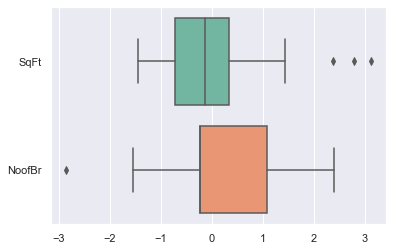

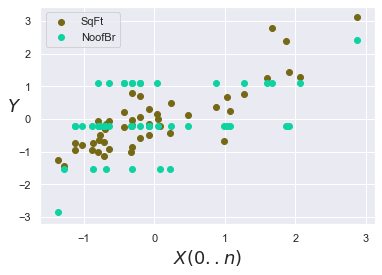

Features Correlation with Target :
SqFt      0.854988
NoofBr    0.442261
Cost      1.000000
Name: Cost, dtype: float64
Heat Map
Pair Plot showing the correlation of Index(['SqFt', 'NoofBr'], dtype='object') to the target Cost


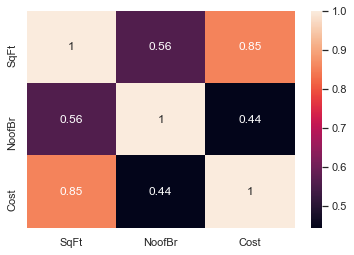

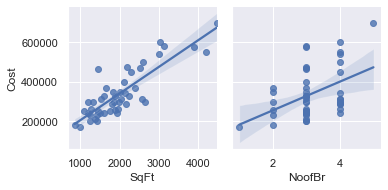

In [113]:
print_line()
eda = EDA(True, True, True, True, True, True)
eda.describe('MV.txt', 'Cost')

                              Single Variable EDA                               
EDA initialized and set to Describe [ True ], DType Check [ True ], Null Check [ True ], Outlier Check [ True ], Plot Graphs [ True ]
EDA for DataFrame : SingleVariable.txt
Given Data Frame is of size  Rows[97], columns[2]
               X          Y
count  97.000000  97.000000
mean    8.159800   5.839135
std     3.869884   5.510262
min     5.026900  -2.680700
25%     5.707700   1.986900
50%     6.589400   4.562300
75%     8.578100   7.046700
max    22.203000  24.147000
No of Columns in DataFrame with Null values : 0
Existence of Object or String type in the DataFrame : False
Visualization of Data - Plots[Box, Scatter, Correlation HeatMap, Correlation]
Existence of Outlier for the Column [X] and the No. of Outliers present : 4


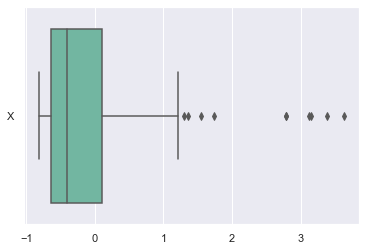

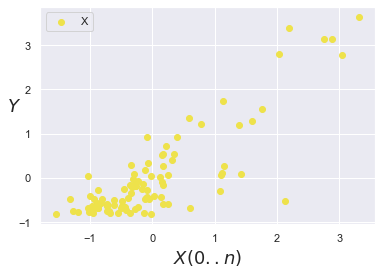

Features Correlation with Target :
X    0.837873
Y    1.000000
Name: Y, dtype: float64
Heat Map
Pair Plot showing the correlation of Index(['X'], dtype='object') to the target Y


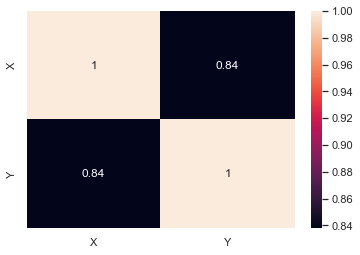

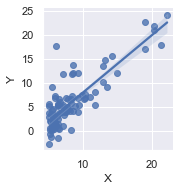

In [115]:
print_line()
print("Single Variable EDA".center(80, ' '))
print_line()
eda = EDA(True, True, True, True, True, True)
eda.describe('SingleVariable.txt', 'Y')